# MOCO

## SETUP

In [2]:
%cd ~/Documents/TESI/TESI/notebooks
%load_ext autoreload
%autoreload 2

/home/zano/Documents/TESI/TESI/notebooks


This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.


In [3]:
# import os
import re
import tifffile
import glob
# import random
import torch
import pytorch_lightning as pl
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from utils.train_functions import (
# train_epoch,
# val_epoch,
# print_model_summary,
# plot_cv_results,
# train_epoch_mixUp,
# print_layers,
# oversample_minority,
# undersample_majority,
# freeze_layers_up_to,
# freeze_layers_up_to_progressive_ft,
train_epoch_vit,
val_epoch_vit,
)

import utils.transformations_functions as tf
# Removed redundant import: from configs.ConfigLoader import ConfigLoader

from classes.ModelManager import ModelManager
import monai
print(monai.__version__)
#import tifffile
#from monai.networks.nets import DenseNet121
# import torch.nn.functional as F
# from monai.visualize.class_activation_maps import GradCAMpp,GradCAM  
#kaggle = input("Are you on Kaggle? Enter 'T' for True or 'F' for False:


2.6.0+cu124
1.4.0


In [4]:
from utils.setup_functions import set_environment_flags
# Example usage:
environment_flags = set_environment_flags()
kaggle,gdrive,linux = environment_flags["kaggle"], environment_flags["gdrive"], environment_flags["linux"]
from utils.reproducibility_functions import set_global_seed
set_global_seed(42)

Environment settings: {'gdrive': False, 'linux': True, 'kaggle': False, 'ssl': True}


In [5]:
# start mlflow ui
from utils.mlflow_functions import *
from utils.directory_functions import *

tracking_uri = get_tracking_uri(gdrive,kaggle,linux)
mlflow.set_tracking_uri(tracking_uri)
start_mlflow_ui(tracking_uri) # start mlflow ui

you are on linux
Linux detected, setting tracking URI
Final Tracking URI: /home/zano/Documents/TESI/mlruns
Does the directory exist? True


In [6]:
num_input_channels = int(input("Enter the number of input channels (3 or 4): "))
from utils.directory_functions import get_data_and_base_directory
data_dir, base_dir = get_data_and_base_directory(environment_flags["kaggle"], environment_flags["gdrive"], environment_flags["linux"], num_input_channels=num_input_channels)

3 channels input
you are in linux
/home/zano/Documents/TESI/3c_MIP_new


# DATA EXTRACTION

In [7]:
import ipywidgets as widgets
from IPython.display import display

CLASS_NAME_SETS = {
    "MSA vs Control": ["MSA", "control"],
    "MSA vs PD": ["MSA", "PD"],
    "MSA-P vs MSA-C": ["MSA-P", "MSA-C"],
    "MSA-P vs PD": ["MSA-P", "PD"],
    "PD vs MSA-P vs MSA-C": ["PD", "MSA-P", "MSA-C"]
}

dropdown = widgets.Dropdown(
    options=list(CLASS_NAME_SETS.keys()),
    value="MSA vs PD",
    description='Class Set:',
    style={'description_width': 'initial'}
)

def on_dropdown_change(change):
    """
    Update the class_names variable when the dropdown selection changes.
    """
    global class_names
    if change['type'] == 'change' and change['name'] == 'value':
        class_names = CLASS_NAME_SETS[change['new']]
        print(f"class_names set to: {class_names}")


class_names = CLASS_NAME_SETS[dropdown.value]

dropdown.observe(on_dropdown_change)

display(dropdown)

Dropdown(description='Class Set:', index=1, options=('MSA vs Control', 'MSA vs PD', 'MSA-P vs MSA-C', 'MSA-P v…

In [8]:
## Paths of ALL images into a numpy array without labels used for SSL
def from_tif_folder_to_np_paths_array(folder_path: str) -> np.ndarray:
    """
    Load all .tif images from a folder into a numpy array.
    """
    image_paths = glob.glob(os.path.join(folder_path, "*.tif"))
    image_paths_np = np.array(image_paths)
    print(f"Number of images in {folder_path}: {len(image_paths)}")
    return image_paths_np

all_images_folder_path = os.path.join(data_dir, "ALL")
all_images_paths = from_tif_folder_to_np_paths_array(all_images_folder_path)
print("Number of images in ALL folder:", len(all_images_paths))

Number of images in /home/zano/Documents/TESI/3c_MIP_new/ALL: 152
Number of images in ALL folder: 152


In [9]:
## Paths of ALL images into a numpy array without labels used for SSL
print(class_names)
if class_names == ['MSA-P', 'PD']:
    ssl_images_folder_path = os.path.join(data_dir, "CONTROL+MSA-C")
else:
    ssl_images_folder_path = os.path.join(data_dir, "CONTROL")
    

ssl_images_paths_np = from_tif_folder_to_np_paths_array(ssl_images_folder_path)
print(f"Number of images in {ssl_images_folder_path} folder:", len(ssl_images_paths_np))

['MSA', 'PD']
Number of images in /home/zano/Documents/TESI/3c_MIP_new/CONTROL: 19
Number of images in /home/zano/Documents/TESI/3c_MIP_new/CONTROL folder: 19


{'MSA': '/home/zano/Documents/TESI/3c_MIP_new/MSA', 'PD': '/home/zano/Documents/TESI/3c_MIP_new/PD'}
Class directories:
{'MSA': '/home/zano/Documents/TESI/3c_MIP_new/MSA', 'PD': '/home/zano/Documents/TESI/3c_MIP_new/PD'}
MSA images (before filtering): 'gh' count: 83, 'vaso' count: 0
Number of glandular images before filtering: 83
Number of glandular images after filtering: 83
PD images (before filtering): 'gh' count: 57, 'vaso' count: 0
Number of glandular images before filtering: 57
Number of glandular images after filtering: 57


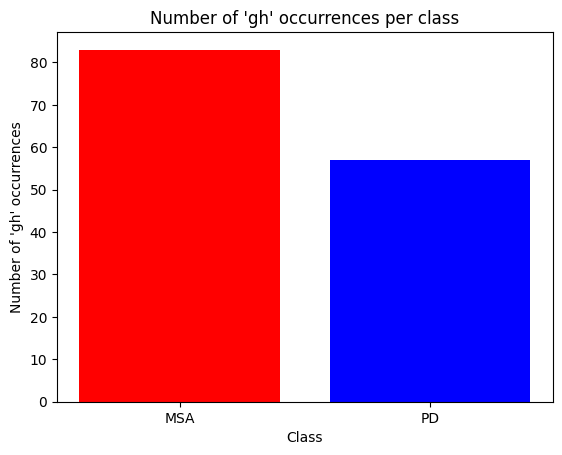


Checking image shapes:
MSA image: MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5435 gh.tif.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5435 gh2.tif.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5463 gh.tif.tif  dt

In [10]:
# Create a dictionary mapping each class to its directory
class_dirs = {} # { "class_name": "path/to/class_dir", "class_name2": "path/to/class_dir2", ... }
is_three_classes = (len(class_names) == 3)

for class_name in class_names:
    class_dirs[class_name] = os.path.join(data_dir, class_name)
    
print(class_dirs)
if is_three_classes:
    class2_name, class1_name, class0_name = class_names
    class2_dir, class1_dir, class0_dir = class_dirs.values()
else:
    class1_name, class0_name = class_names
    class1_dir, class0_dir = class_dirs.values()

print("Class directories:")
print(class_dirs)

# Dictionaries to store image paths and counts for each class
images_paths_dict = {}
counts_dict = {}

# Loop over classes to process each folder
for class_name in class_names:
    class_dir = class_dirs[class_name]
    image_paths = sorted(glob.glob(os.path.join(class_dir, "*.tif")))
    
    # Check if images were found; otherwise raise an error
    if not image_paths:
        raise FileNotFoundError(f"No TIFF image file found in {class_dir}")
    
    # Count occurrences of 'gh' and 'vaso' in the filenames (using .lower() for case insensitivity)
    gh_count = sum('gh' in os.path.basename(path).lower() for path in image_paths)
    vaso_count = sum('vaso' in os.path.basename(path).lower() for path in image_paths)
    print(f"{class_name} images (before filtering): 'gh' count: {gh_count}, 'vaso' count: {vaso_count}")
    
    # Filter out images that contain 'vaso' (if needed)
    from utils.data_extraction_functions import remove_non_gland_images
    image_paths = remove_non_gland_images(image_paths)
    # counts after filtering
    gh_count_after = sum('gh' in os.path.basename(path).lower() for path in image_paths)
    vaso_count_after = sum('vaso' in os.path.basename(path).lower() for path in image_paths)
    # print(f"After removing 'vaso', {class_name} images: 'gh' count: {gh_count_after}, 'vaso' count: {vaso_count_after}")
    
    # Store the filtered image paths and counts for later use
    images_paths_dict[class_name] = image_paths
    counts_dict[class_name] = {"gh_count": gh_count_after, "vaso_count": vaso_count_after}

# Visualize the number of 'gh' counts per class in a bar chart
# def plot_counts_bar_chart(counts_dict, class_names):
#     """
#     Plot a bar chart of counts for each class.
#     """
#     plt.figure(figsize=(10, 6))
#     plt.bar(class_names, [counts_dict[cn]["gh_count"] for cn in class_names], color='blue')
#     plt.xlabel("Class")
#     plt.ylabel("Number of 'gh' occurrences")
#     plt.title("Number of 'gh' occurrences per class")
#     plt.show()

plt.figure()
plt.xlabel("Class")
plt.ylabel("Number of 'gh' occurrences")
plt.title("Number of 'gh' occurrences per class")
bar_heights = [counts_dict[cn]["gh_count"] for cn in class_names]
bar_colors = ['red', 'blue', 'lightblue']
plt.bar(class_names, bar_heights, color=bar_colors)
plt.show()

# --- Debug: Check image shapes after initial loading ---
print("\nChecking image shapes:")
for class_name, image_paths in images_paths_dict.items():
    for path in image_paths:
        img = tifffile.imread(path)  # Read image as a numpy array
        print(f"{class_name} image: {os.path.basename(path)}  dtype: {img.dtype}, shape: {img.shape}")

# Combine image paths and labels for the three classes; 
# the label here is simply the index of the class in class_names (0, 1, 2)
combined = [] # List to store tuples of (image_path, label)
for label, class_name in enumerate(class_names):
    for path in images_paths_dict[class_name]:
        combined.append((path, label))
# print("\nSample of combined image paths and labels:", combined[:5])
# random.shuffle(combined)  # Shuffle the combined list to mix classes

# Optionally, determine the minority label for resampling purposes
counts = {label: len(images_paths_dict[class_name]) for label, class_name in enumerate(class_names)}
minority_label = min(counts.keys(), key=lambda k: counts[k])
print(f"\nMinority label for resampling purposes: {minority_label}")

# Unzip the combined list back into separate tuples (if needed)
images_paths, labels = zip(*combined)
print("\nSample of image paths:", images_paths[:5])
print("Total images found:", len(combined))

# Optionally, convert to NumPy arrays (helpful for further processing or k-fold splitting)
images_paths_np = np.array(images_paths)
labels_np = np.array(labels)
print("\nSample of image paths (NumPy):", images_paths_np[:5])
print((labels_np))
#print(X)

Original dataset size: 140
Original label distribution: {0: 83, 1: 57}

Aiming for a balanced test set with 57 samples per class.
Total balanced test set size will be: 114
Test set size: 114

Test set distribution: {0: 57, 1: 57}


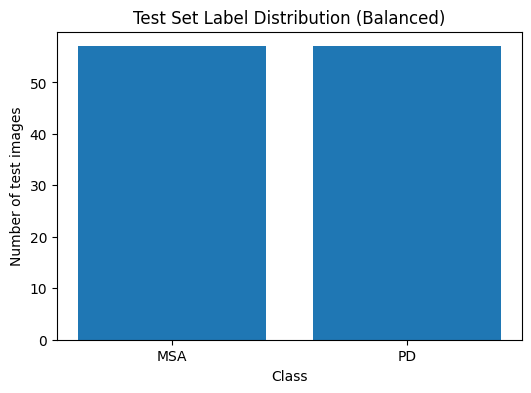


Test set counts and percentages:
MSA: 57 images (50.0% of test set)
PD: 57 images (50.0% of test set)


In [11]:
# --- Your Split Logic for 50/50 distribution in test set ---
print("Original dataset size:", len(images_paths_np))

# Find unique labels and their counts in the original dataset
unique_labels, counts = np.unique(labels_np, return_counts=True)
original_distribution = dict(zip(unique_labels, counts))
print(f"Original label distribution: {original_distribution}")

# Determine the maximum possible size for a balanced test set per class
# This is limited by the count of the smallest class
if len(unique_labels) > 1:
    min_class_count = min(counts)
    # We want a balanced test set, so take 'min_class_count' samples from each class
    test_samples_per_class = min_class_count
    total_balanced_test_size = test_samples_per_class * len(unique_labels)

    print(f"\nAiming for a balanced test set with {test_samples_per_class} samples per class.")
    print(f"Total balanced test set size will be: {total_balanced_test_size}")

    test_indices = []
    train_indices = []

    # Iterate through each class to split
    for label in unique_labels:
        # Get the indices in the original array that correspond to the current class
        # print ( labels_np == label) # returns a boolean array
        class_indices = np.where(labels_np == label)[0]  #use the boolean array to get the indices where cond is true 
        # print(f"\nClass {label} indices: {class_indices}") #retuns the indices of the class in the original array and the boolarray so we use [0] to get the indices

        # Randomly select a fixed number of indices for the test set from this class
        # Use np.random.choice with replace=False for sampling without replacement
        # Set a random_state for reproducibility if needed
        rng = np.random.default_rng(42) # Use new random generator recommended over np.random.seed
        test_class_indices = rng.choice(
            class_indices,
            size=test_samples_per_class,
            replace=False
        )
        test_indices.extend(test_class_indices)

    # Convert lists of indices to NumPy arrays
    test_indices = np.array(test_indices)
    train_indices = np.array(train_indices)

    # Shuffle the indices to mix up the classes in the final arrays (optional but good practice)
    # rng.shuffle(test_indices)
    # rng.shuffle(train_indices)

    balanced_test_images_paths = images_paths_np[test_indices]
    balanced_test_true_labels = labels_np[test_indices]
    print(f"Test set size: {len(balanced_test_images_paths)}")

    # Verify the test set distribution
    test_unique_labels, test_counts = np.unique(balanced_test_true_labels, return_counts=True)
    test_distribution = dict(zip(test_unique_labels, test_counts))
    print(f"\nTest set distribution: {test_distribution}")


    plt.figure(figsize=(6, 4))
    # Use test_unique_labels and test_counts for the bar plot
    labels_for_plot = [class_names[label] if 'class_names' in locals() else f"Label {label}" for label in test_unique_labels]
    plt.bar(labels_for_plot, test_counts)
    plt.xlabel("Class")
    plt.ylabel("Number of test images")
    plt.title("Test Set Label Distribution (Balanced)")
    plt.show()

    # Print counts and percentages for the balanced test set
    print("\nTest set counts and percentages:")
    for label, count in zip(test_unique_labels, test_counts):
         class_name = class_names[label] if 'class_names' in locals() else f"Label {label}"
         print(f"{class_name}: {count} images ({count/len(balanced_test_true_labels):.1%} of test set)")

else:
    print("Cannot perform a balanced split with less than two unique classes.")

119 training images
21 test images
<class 'numpy.ndarray'>


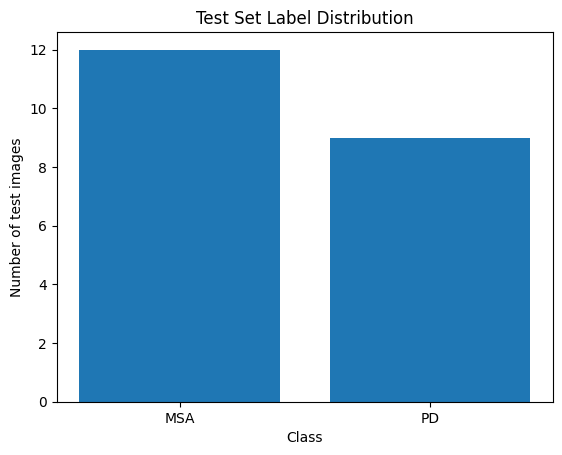

Label 0 (MSA): 12 images
Label 1 (PD): 9 images
Label 0 (MSA) is: 0.5714285714285714
Label 1 (PD) is: 0.42857142857142855


In [12]:
# NB the test set must be splitted BEFORE oversampling to avoid data leakage!
# -------------------------------------------------------------------------
#from sklearn.model_selection import train_test_split
#returns numpy arrays containing the paths to images and the labels
train_images_paths, test_images_paths, train_true_labels, test_true_labels = train_test_split(
    images_paths_np,
    labels_np,
    test_size= 0.15,
    stratify=labels,
    random_state=42,
)

test_images_paths_np = np.array(test_images_paths)
test_true_labels_np = np.array(test_true_labels)
# print("train images paths:", train_images_paths)
# print("true test labels:", test_true_labels)
# # For the cross-validation, we'll use train_images_paths and labels_temp
train_images_paths_np = np.array(train_images_paths) #contains the images paths
train_labels_np = np.array(train_true_labels) #contains the labels
print(f"{train_images_paths_np.shape[0]} training images")
print(f"{len(test_images_paths)} test images")
#test_images_paths = [os.path.basename(path) for path in test_images_paths]
# print(test_images_paths)
print(type(train_images_paths))

unique_labels, counts = np.unique(test_true_labels_np, return_counts=True)


plt.bar([class_names[label] for label in unique_labels], counts)
plt.xlabel("Class")
plt.ylabel("Number of test images")
plt.title("Test Set Label Distribution")
plt.show()

for label, count in zip(unique_labels, counts):
    print(f"Label {label} ({class_names[label]}): {count} images")

for label, count in zip(unique_labels, counts):
    print(f"Label {label} ({class_names[label]}) is: {count/test_true_labels_np.shape[0]}")

In [13]:
def extract_patient_id(image_path):
    # Example: parse from the file name
    # In real code, you might have a different pattern
    match = re.search(r'(\d{4})', image_path)
    if match:
        return match.group(1)
    else:
        return "UNKNOWN"

# Build a DataFrame
df = pd.DataFrame({
    "image_path": images_paths_np,
    "label": labels_np
})

df["patient_id"] = df["image_path"].apply(extract_patient_id)

display(df)

# Ensure everything is string or int
df["patient_id"] = df["patient_id"].astype(str)

# Now group by patient to get a single label per patient.
# If every patient truly has exactly one label, we can just take .first()
patient_label_df = df.groupby("patient_id", as_index=False)["label"].first()

unique_pat_ids = patient_label_df["patient_id"].values  # need these to stratify for patient
print(f"Unique patient IDs: {unique_pat_ids}")
print(f"Number of unique patients: {len(unique_pat_ids)}")
pat_labels = patient_label_df["label"].values
print(f"Unique patient labels: {pat_labels}")

patient_label_df

,image_path,label,patient_id
0,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_4...,0,4092
1,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_4...,0,4092
2,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_4...,0,4121
3,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_4...,0,4121
4,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_5...,0,5358
...,...,...,...
135,/home/zano/Documents/TESI/3c_MIP_new/PD/MAX_74...,1,7461
136,/home/zano/Documents/TESI/3c_MIP_new/PD/MAX_75...,1,7544
137,/home/zano/Documents/TESI/3c_MIP_new/PD/MAX_76...,1,7677
138,/home/zano/Documents/TESI/3c_MIP_new/PD/MAX_76...,1,7688


Unique patient IDs: ['4092' '4121' '5358' '5435' '5463' '5717' '5745' '5753' '5767' '5776'
 '5878' '5881' '5904' '5954' '5969' '5978' '5992' '5996' '6008' '6046'
 '6053' '6060' '6085' '6179' '6308' '6311' '6320' '6323' '6326' '6337'
 '6340' '6351' '6363' '6366' '6375' '6383' '6424' '6427' '6459' '6485'
 '6491' '6571' '6577' '6593' '6599' '6616' '6651' '6657' '6663' '6690'
 '6696' '6749' '6773' '6791' '7105' '7120' '7132' '7144' '7155' '7179'
 '7185' '7191' '7222' '7229' '7239' '7284' '7293' '7343' '7461' '7544'
 '7579' '7677' '7688' '7710']
Number of unique patients: 74
Unique patient labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1
 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1]


,patient_id,label
0,4092,0
1,4121,0
2,5358,0
3,5435,0
4,5463,0
...,...,...
69,7544,1
70,7579,0
71,7677,1
72,7688,1


# MOCO v2


Using fixed, hand-extracted patches as your only “images” for MoCo-v2 pretraining usually isn’t ideal—MoCo-v2 (and most SSL methods) rely on random crops of various scales so the network learns both global structure and fine details.

In [ ]:
from configs.ConfigLoader import ConfigLoader
import utils.transformations_functions as tf
from classes.ModelManager import ModelManager

yaml_path = f"/home/zano/Documents/TESI/TESI/configs/{num_input_channels}c/resnet18.yaml"
cfg = ConfigLoader(yaml_path) 
cfg.set_freezed_layer_index(None)
transfer_learning = cfg.get_transfer_learning()
pretrained_weights = "imagenet" if transfer_learning else "" # 'microscopynet' or "imagenet"
model_library = "torchvision" # or "torchvision" or "monai"
color_transforms = False
train_transforms, val_transforms, test_transforms = tf.get_transforms(cfg)
model_manager = ModelManager(cfg, library=model_library)
# Verify the number of unique labels in the dataset
num_classes = len(np.unique(train_labels_np))
print(f"Number of classes in the dataset: {num_classes}")

# Ensure the model's output matches the number of classes
model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)

print(model)
print(cfg.get_model_input_channels())

Configuration loaded from /home/zano/Documents/TESI/TESI/configs/3c/base.yaml
Configuration: {'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 6}, 'data_augmentation': {'resize_spatial_size': [256, 256], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.4, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1}, 'data_loading': {'batch_size': 8, 'num_workers': 0}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 3, 'out_channels': 2, 'dropout_prob': 0.1}, 'training': {'num_epochs': 50, 'early_stopping_patience': 17, 'mixup_alpha': 0, 'oversample': True, 'undersample': False, 'weighted_loss': False, 'fine_tuning': False, 'transfer_learning': True, 'freezed_layerIndex': None}, 'optimizer': {'learning_rate': '1e-4', 'optimizer_name': 'Adam', 'weight_decay': '2e-5'}, 'scheduler': {'scheduler_name': 'ReduceLROnPlateau', 'factor': 0.

In [15]:
# this is the code to define callbacks for pl training early stopping with knn evaluation accuracy as metric
import torch
import torch.nn.functional as F
from utils.train_functions import make_loader

# Function to evaluate k-NN accuracy
# This function computes the k-NN accuracy of a given backbone model on a specified data loader.
# It uses cosine similarity and temperature-scaled softmax voting to determine the accuracy.
@torch.no_grad()
def knn_eval(backbone, loader, k=20, temperature=0.1, device="cuda"):
    """
    Compute k-NN top1 accuracy of `backbone` on `loader`.
    Uses cosine similarity and temperature-scaled softmax voting.
    """
    backbone.eval()
    feats, labels = [], []

    for batch in loader:
        x = batch["image"].to(device, non_blocking=True)
        y = batch["label"].to(device, non_blocking=True)
        feats.append(backbone(x).flatten(start_dim=1))
        labels.append(y)
    feats = torch.cat(feats)                    # [N, D]
    labels = torch.cat(labels)                  # [N]
    feats = F.normalize(feats, dim=1)

    # cosine similarity of each sample to every other
    sim = feats @ feats.t() / temperature       # [N, N]
    _, idx = sim.topk(k=k + 1, largest=True)    # self in first position

    # Exclude itself
    idx = idx[:, 1:]                            # [N, k]

    top1 = 0
    for i in range(feats.size(0)):
        neigh_labels = labels[idx[i]]           # labels of k neighbours
        # majority vote (temperature already applied in sim)
        pred = torch.mode(neigh_labels)[0]
        top1 += int(pred == labels[i])
    return top1 / feats.size(0)


import pytorch_lightning as pl

#lightning callback to evaluate k-NN accuracy
class KNNMonitor(pl.Callback):
    """
    Compute k-NN accuracy on a fixed probe set every `frequency` epochs.
    Logs it as 'knn_acc' so EarlyStopping can watch it.
    """
    def __init__(self, probe_loader, k=20, frequency=1, temperature=0.1, device=None):
        super().__init__()
        self.probe_loader = probe_loader
        self.k = k
        self.freq = frequency
        self.temp = temperature
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    def on_train_epoch_end(self, trainer, pl_module):
        # run only every `frequency` epochs
        if (trainer.current_epoch + 1) % self.freq != 0:
            return

        acc = knn_eval(
            backbone=pl_module.backbone,        # online encoder
            loader=self.probe_loader,
            k=self.k,
            temperature=self.temp,
            device=self.device,
        )
        # log so that EarlyStopping can monitor it
        pl_module.log("knn_acc", acc, prog_bar=True, on_epoch=True, logger=True)
        epoch = trainer.current_epoch
        print(f"[Epoch {epoch}]  k-NN accuracy: {acc*100:.2f}%")

# Create a new DataLoader for knn test used for early stopping
test_images_paths_np = np.array(balanced_test_images_paths)
test_true_labels_np = np.array(balanced_test_true_labels)

knn_loader = make_loader(
    balanced_test_images_paths,
    test_true_labels_np,
    transforms=val_transforms,
    cfg=cfg,
    shuffle=False,
)

from pytorch_lightning.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="knn_acc",
    mode="max",        # we want accuracy to go UP
    patience=100,        # stop if no improvement in 5 evals
    min_delta=0.0,
    check_on_train_epoch_end=True,
)

knn_cb = KNNMonitor(
    probe_loader=knn_loader,
    k=20,
    frequency=1,       # every epoch
)

class PrintEpochLossCallback(pl.Callback):
    """
    Prints the epoch-level loss after each training epoch.
    Assumes you log a metric called 'train_loss'.
    """

    def on_train_epoch_end(self, trainer, pl_module):
        # 'trainer.callback_metrics' holds the metrics you logged this epoch
        epoch_loss = trainer.callback_metrics.get("train_loss")
        current_epoch = trainer.current_epoch
        if epoch_loss is not None:
            print(f"[Epoch {current_epoch}] => train_loss: {epoch_loss:.4f}")
        else:
            print(f"[Epoch {current_epoch}] => train_loss not found!")

print_epoch_loss = PrintEpochLossCallback()

In [20]:
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset
from pathlib import Path
import random
import tifffile
import numpy as np # Ensure numpy is imported as np
import torch # Ensure torch is imported
from PIL import Image # For resizing if needed, though TF.resize is used for tensors
from utils.transformations_functions import from_GBR_to_RGB

class RandomPatchDataset(Dataset):
    def __init__(self, paths, patch_size=256, patches_per_image=8, transform=None):
        self.paths = list(map(Path, paths))
        self.ps = patch_size
        self.np = patches_per_image
        self.transform = transform

    def __len__(self):
        # length is “virtual”: n_images × patches_per_image
        return len(self.paths) * self.np

    def __getitem__(self, idx):
        img_path = self.paths[idx // self.np]
        img_np = tifffile.imread(img_path) # img_np is NumPy array

        # Ensure img_np is CHW (Channel, Height, Width)
        if img_np.ndim == 2:  # Grayscale (H, W)
            # Stack to (3, H, W) for RGB, assuming 3 channels are desired
            img_np = np.stack((img_np,) * 3, axis=0)
        elif img_np.ndim == 3:
            # Check if it's HWC (e.g., H, W, C where C is 3 or 4)
            if img_np.shape[-1] in [3, 4] and img_np.shape[0] > 4: # Heuristic: if last dim is small and first is large
                img_np = np.transpose(img_np, (2, 0, 1))  # Convert HWC to CHW
            elif img_np.shape[0] not in [3, 4]: # Neither CHW nor convertible HWC
                 raise ValueError(f"Image {img_path} has unexpected shape: {img_np.shape}. Expected CHW or HWC with 3/4 channels.")
            # If img_np.shape[0] is [3,4], it's already CHW, do nothing.
        else:
            raise ValueError(f"Image {img_path} has unsupported dimensions: {img_np.ndim}")

        img_tensor = torch.from_numpy(img_np) # img_tensor is now CHW

        # Apply GBR to RGB conversion (expects CHW tensor)
        img_tensor_rgb = from_GBR_to_RGB(img_tensor) # Should return CHW tensor

        _c, h, w = img_tensor_rgb.shape

        # Handle images smaller than the patch size by resizing them (maintaining CHW)
        if h < self.ps or w < self.ps:
            target_h = max(h, self.ps)
            target_w = max(w, self.ps)
            # TF.resize expects CHW tensor and [H, W] size
            img_tensor_rgb = TF.resize(img_tensor_rgb, [target_h, target_w], interpolation=TF.InterpolationMode.BILINEAR, antialias=True)
            _c, h, w = img_tensor_rgb.shape # Update dimensions

        # Randomly select top-left coordinates for the patch
        y = random.randint(0, h - self.ps)
        x = random.randint(0, w - self.ps)
        
        # Extract patch from CHW tensor
        patch_tensor = img_tensor_rgb[:, y:y+self.ps, x:x+self.ps]

        # Ensure the patch_tensor is in a suitable data type for to_pil_image
        # TF.to_pil_image handles CHW float tensor in [0,1] or CHW byte tensor in [0,255].
        if patch_tensor.dtype != torch.uint8:
            if patch_tensor.is_floating_point():
                if patch_tensor.min() >= 0 and patch_tensor.max() <= 1:
                    patch_tensor = (patch_tensor * 255).type(torch.uint8)
                else: # Attempt to normalize or just cast, may need adjustment based on data range
                    # Forcing to uint8; consider if normalization/clipping is needed first
                    patch_tensor = torch.clamp(patch_tensor, 0, 255).type(torch.uint8) 
            else: # Other integer types
                patch_tensor = patch_tensor.type(torch.uint8) # Direct cast, might lose precision

        patch_pil = TF.to_pil_image(patch_tensor) # Expects CHW tensor or HWC numpy

        if self.transform:
            # self.transform (MoCoV2Transform) is expected to return two views (tensors)
            return self.transform(patch_pil)
        else:
            return patch_pil

In [ ]:
import copy
from re import S

import pytorch_lightning as pl
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
# Lightly imports
from lightly.data import LightlyDataset
from lightly.loss import NTXentLoss
from lightly.models.modules import MoCoProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.moco_transform import MoCoV2Transform
from lightly.utils.scheduler import cosine_schedule


class MoCo(pl.LightningModule):
    """
    A PyTorch Lightning module implementing MoCo v2-like training.
    """

    def __init__(self, encoder, num_ftrs=512, out_dim=128, max_epochs=10):
        """
        Args:
            base_encoder: Which torchvision ResNet to use. e.g. 'resnet18' => 512-d final layer
                          'resnet50' => 2048-d final layer.
            num_ftrs: Dimension of the backbone's output before the final FC.
                      For resnet18 => 512, for resnet50 => 2048.
            out_dim: Dimension of the projection head output (128 typical).
            max_epochs: For scheduling momentum with cosine_schedule.
        """
        super().__init__()
        # Build a standard torchvision backbone (without the final FC)
        # resnet = getattr(torchvision.models, base_encoder)(weights = None)
        self.resnet = encoder
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # remove final FC

        # Projection head for the online encoder
        self.projection_head = MoCoProjectionHead(num_ftrs, num_ftrs, out_dim)

        # Create momentum backbone and head as copies
        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        # Freeze momentum backbone to avoid gradient updates
        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

        # Contrastive loss with memory bank
        # size=(memory_bank_size, out_dim), e.g. memory_bank_size=4096, out_dim=128
        # Use NTXentLoss as recommended in lightly docs for MoCo v2
        self.criterion = NTXentLoss(memory_bank_size=(4096,128), temperature=0.1)

        # We will do a cosine schedule for momentum
        self.max_epochs = max_epochs

    def forward(self, x):
        """
        Forward pass of the online (query) encoder.
        x: (B, C, H, W) => returns the projection vector of shape (B, out_dim).
        """
        query = self.backbone(x).flatten(start_dim=1)    # e.g. shape (B, 512) for resnet18
        query = self.projection_head(query)              # shape (B, out_dim)
        return query

    def forward_momentum(self, x):
        """
        Forward pass of the momentum (key) encoder.
        """
        key = self.backbone_momentum(x).flatten(start_dim=1)
        key = self.projection_head_momentum(key).detach()
        return key

    def training_step(self, batch, batch_idx):
        if batch_idx == 0 and self.current_epoch == 0:
            print("DEBUG shapes:", len(batch), batch[0].shape, batch[1].shape)
        queries_batch, keys_batch = batch # Or batch[0], batch[1]
        q = self.forward(queries_batch)
        k = self.forward_momentum(keys_batch)
        loss = self.criterion(q, k)
        self.log("train_loss", loss, on_epoch=True)
        return loss

    # keep the EMA update *after* optimiser step
    def on_train_batch_end(self, *_):
        m = cosine_schedule(self.current_epoch, self.max_epochs, 0.996, 1.0)
        update_momentum(self.backbone,        self.backbone_momentum,        m)
        update_momentum(self.projection_head, self.projection_head_momentum, m)

    def configure_optimizers(self):
        # batch_size = 32
        opt = torch.optim.SGD(self.parameters(),
                              lr=0.03,
                              momentum=0.9, weight_decay=1e-4)
    
        return opt

# 1) Create the MoCo model with a resnet18 backbone
#    If you want resnet50 => num_ftrs=2048
print("Creating MoCo model...")
max_epochs = 100
model = MoCo(base_encoder="resnet18", num_ftrs=512, out_dim=128, max_epochs=max_epochs)

# 2) Define your transforms
#    MoCoV2Transform returns two views: x_query, x_key
#    input_size=256 => randomly resize/crop to 256
transform = MoCoV2Transform(input_size=cfg.get_image_shape()[0],
                            # cj_prob=0.5,  # color jitter probability
                            # cj_strength=0.5,  # color jitter strength
                            # cj_bright=0.4,  # brightness strength
                            # cj_contrast=0.4,  # contrast strength
                            # cj_sat=0.4,  # saturation strength
                            # gaussian_blur=0.1,  # gaussian blur probability
                            )

# 3) Create a dataset from your unlabeled folder of images
#    e.g., data/unlabeled/
# dataset = LightlyDataset(f"/home/zano/Documents/TESI/{num_input_channels}c_MIP_new/ALL/", transform=transform)
# print("Number of samples in the dataset:", len(dataset))
INPUT_SIZE = 64
# 4) Create a DataLoader
transform = MoCoV2Transform(
    input_size=INPUT_SIZE,           # match patch dimension
    # gaussian_blur=0.3,
    # cj_prob=0.1,
    # cj_strength=0.1,
    # cj_contrast=0.1,
    # cj_bright=0.1,
    # cj_sat=0.1,
    # cj_hue=0.1,
    # sigmas=None,  # sigma range for gaussian blur
    # normalize= None
    
)

ds = RandomPatchDataset(all_images_paths, patch_size=INPUT_SIZE,
                        patches_per_image=10, transform=transform)

print("Number of samples in the dataset:", len(ds))


loader = DataLoader(ds, batch_size=256, shuffle=True,  # TODO: change to a much greater batch size at least 128
                    num_workers=2, drop_last=True
                    )
# 5) Train with PyTorch Lightning
device = "cuda" if torch.cuda.is_available() else "cpu"

trainer = pl.Trainer(
    gradient_clip_val=1.0,
    max_epochs=max_epochs,
    min_epochs=1,
    max_steps=-1, 
    devices=1,
    accelerator=device,
    log_every_n_steps=1,
    precision="32-true",  # mixed precision
    enable_progress_bar=False,            # turn off TQDM updates
    callbacks=[
            print_epoch_loss,
            knn_cb,                    
            early_stop,
        ]  # use our custom callback
)

trainer.fit(model=model, train_dataloaders=loader)

# 6) Save your trained model (the "online" part)
#    Typically you keep the backbone for downstream tasks
encoder_name = "moco_backbone_es"
STABLE_BACKBONE_PATH = encoder_name + ".pth"
encoder_weights = torch.save(model.backbone.state_dict(), STABLE_BACKBONE_PATH)
print(f"MoCo training completed. Saved backbone to {STABLE_BACKBONE_PATH}")

# load the saved model
moco_encoder = MoCo(base_encoder="resnet18", num_ftrs=512, out_dim=128, max_epochs=10)
moco_encoder.backbone.load_state_dict(torch.load(STABLE_BACKBONE_PATH))

In [ ]:
# """
# tiny_moco_patches.py
# --------------------
# MoCo-v2 pre-training on very small datasets by turning each high-resolution
# image into many random 256×256 patches.

# * 10 patches per slide  →  152 slides  →  1 520 virtual samples
# * batch 64 with NVIDIA mixed-precision (fits 12 GB GPU)
# * NT-Xent queue 512 (updates fully every 8 steps)
# * momentum schedule 0.95 → 0.90
# * loss should fall from ≈5.4 to <4 within 10-15 epochs
# """

# from pathlib import Path
# import math, random, copy, tifffile, numpy as np
# import torch, torchvision
# from torch import nn
# from torch.utils.data import Dataset, DataLoader
# from torch.cuda.amp import autocast, GradScaler
# from lightly.loss import NTXentLoss
# from lightly.models.modules import MoCoProjectionHead
# from lightly.models.utils import deactivate_requires_grad, update_momentum
# from lightly.transforms.moco_transform import MoCoV2Transform


# # ------------------------------------------------------------------
# # 1)  Random-patch dataset
# # ------------------------------------------------------------------
# class RandomPatchDataset(Dataset):
#     def __init__(self, paths, patch=256, per_img=10, transform=None):
#         self.paths, self.ps, self.per_img, self.tf = list(paths), patch, per_img, transform

#     def __len__(self):
#         return len(self.paths) * self.per_img     # virtual length

#     def __getitem__(self, idx):
#         img = tifffile.imread(self.paths[idx // self.per_img])
#         if img.ndim == 3 and img.shape[0] <= 4:          # CHW → HWC
#             img = np.transpose(img, (1, 2, 0))
#         h, w = img.shape[:2]; p = self.ps
#         y, x = random.randint(0, h - p), random.randint(0, w - p)
#         patch = img[y:y+p, x:x+p]
#         patch = torchvision.transforms.functional.to_pil_image(patch)
#         return self.tf(patch)            # MoCoV2Transform returns [view_q, view_k]


# # ------------------------------------------------------------------
# # 2)  Simple collate-fn that stacks the two views
# # ------------------------------------------------------------------
# def moco_collate(batch):
#     # batch = [[v_q0, v_k0], [v_q1, v_k1], ...]
#     x_q = torch.stack([b[0] for b in batch], 0)
#     x_k = torch.stack([b[1] for b in batch], 0)
#     return x_q, x_k


# # ------------------------------------------------------------------
# # 3)  MoCo model (ResNet-50 backbone)
# # ------------------------------------------------------------------
# class MoCo(nn.Module):
#     def __init__(self, out_dim=128):
#         super().__init__()
#         resnet = torchvision.models.resnet50(weights=None)
#         self.backbone = nn.Sequential(*list(resnet.children())[:-1])        # 2048-d
#         self.head = MoCoProjectionHead(2048, 2048, out_dim)

#         self.backbone_m = copy.deepcopy(self.backbone)
#         self.head_m     = copy.deepcopy(self.head)
#         deactivate_requires_grad(self.backbone_m)
#         deactivate_requires_grad(self.head_m)

#     def forward(self, x):
#         z = self.backbone(x).flatten(1)
#         return self.head(z)

#     @torch.no_grad()
#     def forward_m(self, x):
#         z = self.backbone_m(x).flatten(1)
#         return self.head_m(z)


# # ------------------------------------------------------------------
# # 4)  Build data loaders
# # ------------------------------------------------------------------  
# img_dir = Path(ssl_images_folder_path)
# paths   = sorted(p for p in img_dir.glob("*.tif*"))        # adapt extension if PNG/JPG

# transform = MoCoV2Transform(
#     input_size=256,
#     gaussian_blur=0.5,
#     cj_prob=0.8,
# )

# from torchvision import transforms

# # overwrite the default RandomResizedCrop with a custom one
# transform.random_resized_crop = transforms.RandomResizedCrop(
#     size=256,
#     scale=(0.5, 1.0),          # ← wider scale range
#     ratio=(3/4, 4/3),
#     interpolation=transforms.InterpolationMode.BICUBIC,
#     antialias=True
# )

# # from torchvision import transforms
# # # from lightly.transforms.utils import GaussianBlur

# # transform = transforms.Compose([
# #     transform.ensure_cha
# #     transforms.RandomResizedCrop(
# #         256, scale=(0.5, 1.0), ratio=(3/4, 4/3),
# #         interpolation=transforms.InterpolationMode.BICUBIC,
# #         antialias=True),
# #     transforms.RandomHorizontalFlip(p=0.5),
# #     transforms.RandomApply([
# #         transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
# #     ], p=0.8),
# #     transforms.RandomGrayscale(p=0.2),
# #     # GaussianBlur(0.5),                       # same as MoCoV2 default
# #     transforms.ToTensor(),
# #     transforms.Normalize(
# #         mean=[0.485, 0.456, 0.406][:num_input_channels],
# #         std =[0.229, 0.224, 0.225][:num_input_channels]),
# # ])

# dataset = RandomPatchDataset(paths, patch=256, per_img=10, transform=transform)
# loader  = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True,
#                      num_workers=4, collate_fn=moco_collate)

# print(f"Slides: {len(paths)}  |  virtual patches/epoch: {len(dataset)}")


# # ------------------------------------------------------------------
# # 5)  Model, optimiser, loss, scaler
# # ------------------------------------------------------------------
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model  = MoCo().to(device)

# criterion = NTXentLoss(memory_bank_size=128, temperature=0.1)
# opt = torch.optim.SGD(model.parameters(), lr=0.03 * (64/256),
#                       momentum=0.9, weight_decay=1e-4)
# scaler = GradScaler()

# # ------------------------------------------------------------------
# # 6)  Training
# # ------------------------------------------------------------------
# epochs = 100
# for ep in range(epochs):
#     model.train()
#     total = 0.0
#     m_val = 0.90 + 0.05 * (1 + math.cos(math.pi * ep / epochs)) / 2   # 0.95→0.90

#     for x_q, x_k in loader:
#         x_q, x_k = x_q.to(device), x_k.to(device)

#         # momentum encoder update *before* forward pass (official MoCo order)
#         update_momentum(model.backbone, model.backbone_m, m_val)
#         update_momentum(model.head,     model.head_m,     m_val)

#         with autocast():                            # mixed precision
#             q = model(x_q)
#             k = model.forward_m(x_k)
#             loss = criterion(q, k)

#         scaler.scale(loss).backward()
#         scaler.step(opt)
#         scaler.update()
#         opt.zero_grad()
#         total += loss.detach()

#     avg = (total / len(loader)).item()
#     print(f"Epoch {ep:03d}  NT-Xent loss: {avg:.4f}")

# print("Finished.  Save backbone with:")
# print("torch.save(model.backbone.state_dict(), 'moco_backbone.pth')")


In [ ]:
#print(model)
import torchvision
from torchvision import models
resnet = getattr(torchvision.models, 'resnet50')(weights = None)
print(*list(resnet.children())[:-2])

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) ReLU(inplace=True) MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
import optuna
from utils.data_visualization_functions import generate_cv_results_figure
from utils.train_functions import train_epoch, undersample_majority, val_epoch, train_epoch_mixUp, oversample_minority
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from monai.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

# Example usage in a PyTorch Lightning module for supervised fine-tuning:
class SSLClassifierModule(pl.LightningModule):
    def __init__(self, encoder: nn.Module, num_classes: int = 2, freeze_encoder: bool = True, backbone_output_dim: int = None, lr: float = 1e-4):
        super().__init__()
        self.save_hyperparameters(ignore=["encoder"])
        self.classifier_model = BaseSSLClassifier(encoder, num_classes, freeze_encoder, backbone_output_dim)
        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = lr

    def forward(self, x):
        return self.classifier_model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.loss_fn(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.loss_fn(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.loss_fn(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        self.log("test_loss", loss, on_epoch=True)
        self.log("test_acc", acc, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=self.lr)




from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd,
    RandFlipd, RandRotate90d, Resized, ToTensord, NormalizeIntensityd
)

# Define transforms for training with data augmentation
train_transforms = Compose([
    LoadImaged(keys=["image"], reader="itkreader"),  # Load the image from disk
    EnsureChannelFirstd(keys=["image"]),  # Convert to channel-first format
    LambdaD(keys=["image"], func=lambda x: x[:3, ...]),  # Keep only first 3 channels
    Resized(keys=["image"], spatial_size=(224, 224)),  # Resize to match model input
    RandFlipd(keys=["image"], prob=0.5),  # Random horizontal flips
    ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),  # Scale to [0, 1]
    # NormalizeIntensityd(
    #     keys=["image"], 
    #     mean=[0.485, 0.456, 0.406], 
    #     std=[0.229, 0.224, 0.225]
    # ),  # ImageNet normalization
    ToTensord(keys=["image"]),  # Convert to PyTorch tensor
])

# Define transforms for validation/testing (no augmentations)
val_transforms = Compose([
    LoadImaged(keys=["image"], reader="itkreader"),  # Load the image from disk
    EnsureChannelFirstd(keys=["image"]),
    LambdaD(keys=["image"], func=lambda x: x[:3, ...]),  # Keep only first 3 channels
    Resized(keys=["image"], spatial_size=(224, 224)),
    ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),
    # NormalizeIntensityd(
    #     keys=["image"], 
    #     mean=[0.485, 0.456, 0.406], 
    #     std=[0.229, 0.224, 0.225]
    # ),
    ToTensord(keys=["image"]),
])

test_transforms = val_transforms  # Same transforms for testing

# Call the function:
results = run_outer_cv_patient_stratified(
    df=df,
    unique_pat_ids=unique_pat_ids,
    pat_labels=pat_labels,
    cfg=cfg,
    encoder = moco_encoder,
    train_transforms=train_transforms,
    val_transforms=val_transforms,
    test_transforms=test_transforms,
)